In [1]:
library(data.table)
library(limma)
library(dplyr)
library(edgeR)
library(tibble)
library(biomaRt)
library(tidyr)
library(stringr)



Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [54]:
## Import gene names

In [55]:
ensembl = useEnsembl(biomart="ensembl", dataset="mmusculus_gene_ensembl", version=100)

In [56]:
gene_annot <- getBM(mart=ensembl, attributes=c('ensembl_gene_id', 'external_gene_name'))

In [139]:
base_dir <- "../"
species <- 'mm'
save_dir <- file.path(base_dir, 'DE_and_abundance')
meta_path <- file.path(base_dir, "meta_data", "meta_data.csv")
counts_path <- file.path(base_dir, "feature_counts", paste0("trimmed_gene_counts_", species, '.csv'))
annot_path <- file.path(base_dir, "feature_counts", paste0("trimmed_FC_gene_annot_", species, '.csv'))

In [140]:
FC_annot <- read.csv(annot_path, row.names=1)
## Select only gene id and length. Note that dplyr will drop row names upon select
## but edgeR expects gene id in row names, so convert gene_id to column, then back, 
## to row names after selecting
FC_annot <- rownames_to_column(FC_annot, var='gene_id')
FC_annot <- dplyr::select(FC_annot, 'gene_id', 'Length')
FC_annot <- column_to_rownames(FC_annot, var='gene_id')

In [141]:
meta <- read.csv(meta_path)

In [142]:
counts <- read.csv(counts_path, row.names=1)

In [143]:
## Change meta sample names to be acceptable variable names

In [144]:
meta$RatID <- factor(meta$RatID)

In [145]:
## Take counts in the filtered sample list 

In [146]:
counts <- dplyr::select(counts, meta$Sample)

In [147]:
## Get differential gene expression list for use in limma

In [148]:
y <- DGEList(counts, genes=FC_annot)

In [149]:
## Define the linear model and get the design matrix

In [150]:
design <- model.matrix(~ 0 + Condition, data=meta)

In [151]:
## Filter the data to remove low expressed genes

In [152]:
keep <- filterByExpr(y, design, min.count=10, min.total.count=15)
y <- y[keep, keep.lib.sizes=FALSE]

In [153]:
## Calculate library normalization factors 

In [154]:
y <- calcNormFactors(y)

In [155]:
y$samples

,group,lib.size,norm.factors
,<fct>,<dbl>,<dbl>
sample_4821_in,1,6269533,1.0061400
sample_4822_in,1,7012222,1.0073508
sample_4823_in,1,7343828,1.0227778
sample_4831_in,1,6448678,1.0217947
sample_4832_in,1,7118852,0.9903188
sample_4833_in,1,7091207,0.9469512
sample_4834_in,1,7659315,0.9118046
sample_4821_out,1,6763010,1.0076563
sample_4822_out,1,6775492,1.0221313


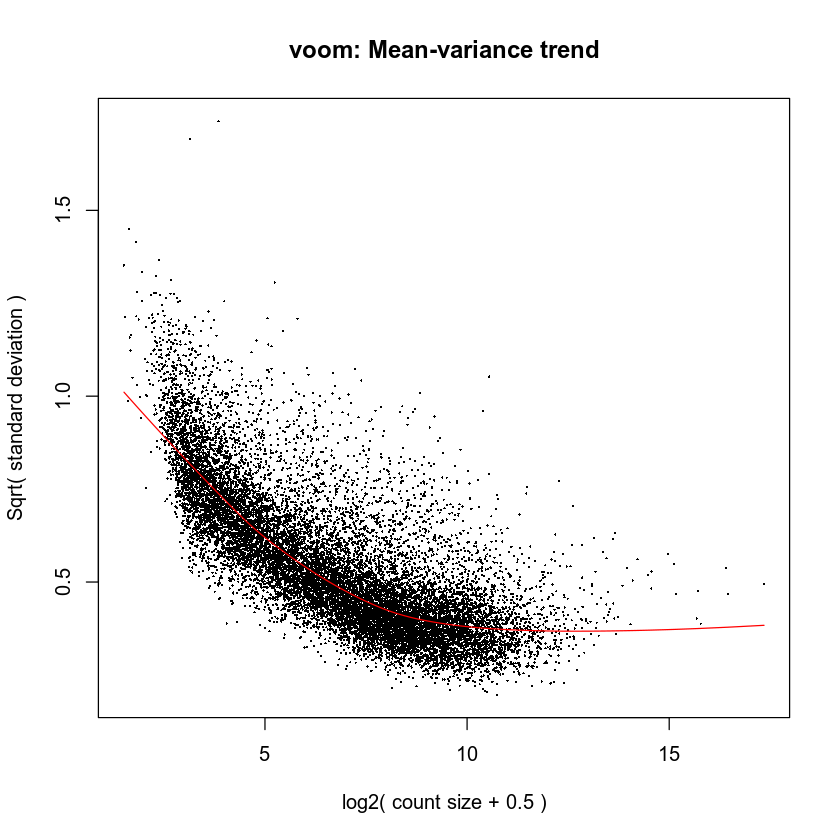

In [156]:
v <- voom(y,design, plot=TRUE)

In [157]:
## Fit the linear model and perform empirical Bayes smoothing

In [158]:
fit <- lmFit(v,design)
fit <- eBayes(fit)

In [159]:
# Get contrasts as all pairs of conditions
conditions <- colnames(design)
contr <- c()
#print(conditions)
for (i in 1:(length(conditions)-1)){
    for (j in (i+1):length(conditions)){
     contrast <- paste0(conditions[i], '-', conditions[j])
        contr <- c(contr, contrast)
    }
}

contrast.matrix <- makeContrasts(contrasts=contr, levels=design)
contrast.matrix

,ConditionAngptl7_KD3_in-ConditionAngptl7_KD3_out,ConditionAngptl7_KD3_in-ConditionNT4_in,ConditionAngptl7_KD3_in-ConditionNT4_out,ConditionAngptl7_KD3_out-ConditionNT4_in,ConditionAngptl7_KD3_out-ConditionNT4_out,ConditionNT4_in-ConditionNT4_out
ConditionAngptl7_KD3_in,1,1,1,0,0,0
ConditionAngptl7_KD3_out,-1,0,0,1,1,0
ConditionNT4_in,0,-1,0,-1,0,1
ConditionNT4_out,0,0,-1,0,-1,-1


In [160]:
## Fit coefficients for contrasts

In [161]:
fit2 <- contrasts.fit(fit, contrast.matrix)
fit2 <- eBayes(fit2)

In [162]:
############################################################
# Prepare DE top tables
############################################################

In [163]:
## Get abundance table with more readable samples names for combining with top table

In [164]:
head(v$E)

,sample_4821_in,sample_4822_in,sample_4823_in,sample_4831_in,sample_4832_in,sample_4833_in,sample_4834_in,sample_4821_out,sample_4822_out,sample_4823_out,sample_4831_out,sample_4832_out,sample_4833_out,sample_4834_out
ENSMUSG00000098104,1.3872049,0.7031239,-0.002134594,0.6722085,0.2698532,0.50053404,1.4054412,0.3187935,0.8519497,-0.6599809,0.9349694,0.04925596,-0.06036314,0.6756733
ENSMUSG00000102175,0.5907383,-0.1199983,0.338902324,-0.9127540,0.9372778,-0.04695375,-1.4820840,-0.9613145,-0.3324748,-1.0225510,1.2244761,-0.57877526,-0.95344793,0.4000389
ENSMUSG00000103922,1.5522642,1.3088450,1.220257827,1.8946009,1.6742434,-0.28796185,0.4439154,0.3187935,0.2955564,1.0280750,1.5376339,0.91598943,0.99408465,1.1965055
ENSMUSG00000033845,5.4382078,5.0713457,5.312561932,5.2827060,4.9000667,4.65774799,5.1414317,5.4577428,5.3552985,5.4108854,5.1828970,5.51446222,5.41661668,5.3394635
ENSMUSG00000102275,1.4720938,0.2670248,0.734831000,1.1378720,1.5399423,0.34006937,0.5883053,1.0893116,1.4934958,1.5276461,0.8239381,0.71668062,1.09717814,1.1063077
ENSMUSG00000025903,4.7047546,4.4879010,4.664621998,4.5973036,4.1991986,4.05350643,3.9968878,4.6364721,5.3192292,4.7662838,4.9114010,4.53544031,4.53840516,4.2967696


In [165]:
voom_counts <- as.data.frame(v$E)
abundance <- 2.**(copy(voom_counts))
abundance <- setnames(abundance, old=meta$Sample, new=meta$Label)
abundance <- rownames_to_column(abundance, var='ensembl_gene_id')

In [166]:
## Get RPKM and convert to TPM

In [167]:
RPKM <- copy(rpkm(y))
TPM <- sweep(RPKM, 2, colSums(RPKM), '/')*(1.e6)
TPM <- setnames(as.data.frame(TPM), old=meta$Sample, new=meta$Label)
TPM <- rownames_to_column(TPM, var='ensembl_gene_id')

In [168]:
## Get top table with logFC and FDR

In [169]:
## Generate empty list to store top tables in 
tt_list <- list()
i <- 1
for (contrast in contr){
    top_table <- topTable(fit2, coef=contrast, number=Inf, sort.by="t")
    top_table <- rownames_to_column(top_table, var='ensembl_gene_id')
    top_table <- left_join(top_table, gene_annot, by='ensembl_gene_id')
    top_table <- dplyr::select(top_table, ensembl_gene_id, external_gene_name, everything())
    tt_list[[i]] <- top_table
    top_table_with_abundance <- left_join(top_table, abundance, by='ensembl_gene_id')
    top_table_with_TPM <- left_join(top_table, TPM, by='ensembl_gene_id')
    contrast_label <- str_remove_all(contrast, 'Condition')
    
    # Save top table (no abundance)
    filename <- paste0('toptable_', species, '_', contrast_label, '.csv')
    savepath <- file.path(save_dir, 'top_tables', filename)
    write.csv(top_table, savepath, row.names=FALSE)
    
    # Save top table with CPM abundance
    filename <- paste0('toptable_and_CPM_', species, '_', contrast_label, '.csv')
    savepath <- file.path(save_dir, 'top_tables_with_CPM_abundance', filename)
    write.csv(top_table_with_abundance, savepath, row.names=FALSE)
    
    # Save top table with TPM abundance
    filename <- paste0('toptable_and_TPM_', species, '_', contrast_label, '.csv')
    savepath <- file.path(save_dir, 'top_tables_with_TPM_abundance', filename)
    write.csv(top_table_with_TPM, savepath, row.names=FALSE)
   
    i <- i + 1
}

In [170]:
################################################
# Prepare a table that combines all DE results
################################################

In [171]:
# replace contrasts with more readable labels

In [172]:
contr_label = str_remove_all(contr, 'Condition')
contr_label = paste0('_', contr_label)

In [173]:
# Join the tables

In [174]:
top_table_all <- tt_list[[1]]
for (i in 1:(length(contr_label)-1)){
    if (i < length(contr_label) -1){ 
        top_table_all <- left_join(top_table_all, tt_list[[i+1]], 
                           by=c('ensembl_gene_id', 'external_gene_name', 'Length'), 
                           suffix = c(contr_label[i], ''))
        } else{
            top_table_all <- left_join(top_table_all, tt_list[[i+1]], 
                               by=c('ensembl_gene_id', 'external_gene_name', 'Length'), 
                               suffix = c(contr_label[i], contr_label[i+1]))
        } 
            
    
}
top_table_all_CPM <- left_join(top_table_all, abundance, by='ensembl_gene_id')
top_table_all_TPM <- left_join(top_table_all, TPM, by='ensembl_gene_id')


In [175]:
# Save the top tables

In [176]:
filename <- paste0('top_table_all_comparisons_',species, '.csv')
savepath <- file.path(save_dir, 'top_tables', filename)
write.csv(top_table_all, savepath, row.names=FALSE)

In [177]:
filename <- paste0('top_table_all_comparisons_', species, 'CPM.csv')
savepath <- file.path(save_dir, 'top_tables_with_CPM_abundance', filename)
write.csv(top_table_all_CPM, savepath, row.names=FALSE)

In [178]:
filename <- paste0('top_table_all_comparisons_', species,'TPM.csv')
savepath <- file.path(save_dir, 'top_tables_with_TPM_abundance', filename)
write.csv(top_table_all_TPM, savepath, row.names=FALSE)

In [179]:
##################################
## Create tidy TPM and counts
#################################

In [180]:
## Cast the TPM table into tidy format and add sample info

In [181]:
RPKM <- copy(rpkm(y))
TPM2 <- sweep(RPKM, 2, colSums(RPKM), '/')*(1.e6)
TPM2 <- rownames_to_column(as.data.frame(TPM2), var='ensembl_gene_id')

In [182]:
TPM.tidy <- pivot_longer(TPM2, -ensembl_gene_id, names_to='Sample', values_to='TPM')
TPM.tidy <- left_join(TPM.tidy, meta, by='Sample')
TPM.tidy <- left_join(TPM.tidy, gene_annot, by='ensembl_gene_id')
TPM.tidy <- dplyr::select(TPM.tidy, ensembl_gene_id, external_gene_name, colnames(meta), everything())

In [183]:
filename <- paste0('TPM_', species, '.csv')
savefile <- file.path(save_dir, 'tidy_abundance_tables', filename)
write.csv(TPM.tidy, savefile)

In [184]:
## Get the voom normalized counts per million

In [204]:
voom_cpm <- v$E
voom_cpm2 <- 2**voom_cpm
voom_cpm3 <- rownames_to_column(as.data.frame(voom_cpm2), var='ensembl_gene_id')
voom_cpm_tidy <- pivot_longer(voom_cpm3, -ensembl_gene_id, names_to='Sample', values_to='CPM')
voom_cpm_tidy <- left_join(voom_cpm_tidy, meta, by='Sample')
voom_cpm_tidy <- left_join(voom_cpm_tidy, gene_annot, by='ensembl_gene_id')
voom_cpm_tidy <- dplyr::select(voom_cpm_tidy, ensembl_gene_id, external_gene_name, colnames(meta), everything())
filename <- paste0('cpm_voom_tidy_',species, '.csv')
voom_cpm_save_file <- file.path(save_dir, 'tidy_abundance_tables', filename)
write.csv(voom_cpm_tidy, voom_cpm_save_file, row.names=FALSE)

In [205]:
## Get tidy raw counts`

In [206]:
counts2 <- rownames_to_column(counts, var='ensembl_gene_id')
genes <- gene_annot['ensembl_gene_id']
counts2 <- dplyr::filter(counts2, ensembl_gene_id %in% gene_annot$ensembl_gene_id)
counts.tidy <- pivot_longer(counts2, -ensembl_gene_id, names_to='Sample', values_to='Counts')
counts.tidy <- left_join(counts.tidy, meta, by='Sample')
counts.tidy <- left_join(counts.tidy, gene_annot, by='ensembl_gene_id')
counts.tidy <- dplyr::select(counts.tidy, ensembl_gene_id, external_gene_name, colnames(meta), everything())

In [207]:
filename <- paste0('Unfiltered_counts_tidy_', species, '.csv')
counts_save_file <- file.path(save_dir, 'tidy_abundance_tables', filename)
write.csv(counts.tidy, counts_save_file, row.names=FALSE)

In [208]:
## Merge 

In [214]:
TPM_counts_tidy <- left_join(TPM.tidy, counts.tidy, by=append(c('ensembl_gene_id', 'external_gene_name'),colnames(meta)))

In [215]:
TPM_cpm_tidy <- left_join(TPM.tidy, voom_cpm_tidy, by=append(c('ensembl_gene_id', 'external_gene_name'),colnames(meta)))

In [216]:
setnamesTPM_counts_cpm <- left_join(TPM_cpm_tidy, counts.tidy, by=append(c('ensembl_gene_id', 'external_gene_name'),colnames(meta)))
TPM_counts_cpm <- dplyr::select(TPM_counts_cpm, ensembl_gene_id, external_gene_name, colnames(meta), everything())

In [217]:
filename <- paste0('TPM_CPM_counts_', species, '.csv')
tpm_cpm_cts_save_file <- file.path(save_dir, 'tidy_abundance_tables', filename)
write.csv(TPM_counts_cpm, tpm_cpm_cts_save_file, row.names=FALSE)